# Creating the Initial Conditions

## Import Libraries and Modules


In [1]:
import gc
import os
import time
from functools import partial
from pathlib import Path

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import netCDF4 as nC4
import numpy as np
from tqdm.notebook import trange, tqdm
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


## JAX Helper Functions & CUDA Check

In [10]:
@partial(jax.jit, static_argnames=("n_levels",))
def create_hfacc_grid_jax(
    depth_jax: jax.Array, delr_jax: jax.Array, n_levels: int
) -> jax.Array:
    """
    Calculates the vertical fraction of open cells (hFacC) using JAX.
    Args:
        depth_jax: 2D JAX array of bathymetry depths (positive down, meters).
                   Should be shape (n_rows, n_cols).
        delr_jax: 1D JAX array of vertical grid cell thicknesses (meters).
                  Shape (n_levels,).
        n_levels: Static integer number of vertical levels.
    Returns:
        A 3D JAX array (hFacC) of shape (n_levels, n_rows, n_cols).
    """
    # Ensure depth is negative for calculations
    depth_neg = -jnp.abs(depth_jax)

    # RF are the depths of the interfaces (negative values, increasing magnitude with depth)
    # Shape (n_levels,)
    rf = -jnp.cumsum(delr_jax)

    depth_3d = depth_neg[None, :, :]  # (1, n_rows, n_cols)

    # RF_3d_bot represents the depth of the *bottom* interface of cell k
    rf_3d_bot = rf[:, None, None]  # (n_levels, 1, 1)

    # hFac calculation: (portion of cell thickness above the seabed) / cell thickness
    # (RF_bottom_interface_depth - seabed_depth) gives distance from bottom interface up to seabed
    # This distance is clamped by delR (cannot be more than cell thickness) and 0 (cannot be less than 0)
    hfac = (
        jnp.maximum(0.0, jnp.minimum(delr_jax[:, None, None], rf_3d_bot - depth_3d))
        / delr_jax[:, None, None]
    )
    hfac = jnp.clip(hfac, 0.0, 1.0)  # Ensure strict [0,1] bounds
    return hfac


@partial(jax.jit, static_argnames=("n_levels", "n_rows", "n_cols"))
def downscale_3d_points_jax_nearest(
    source_xy_jax: jax.Array,  # Shape: (n_source_pts, 2) - [lon, lat]
    source_values_jax: jax.Array,  # Shape: (n_levels, n_source_pts)
    source_mask_jax: jax.Array,  # Shape: (n_levels, n_source_pts) - 1 if valid
    n_levels: int,  # Static: Number of vertical levels for this call
    target_xc_jax: jax.Array,  # Shape: (n_rows, n_cols)
    target_yc_jax: jax.Array,  # Shape: (n_rows, n_cols)
    n_rows: int,  # Static: Number of rows in target grid
    n_cols: int,  # Static: Number of columns in target grid
    target_mask_jax: jax.Array,  # Shape: (n_levels, n_rows, n_cols) - 1 if interp needed
) -> jax.Array:
    """
    Interpolates 3D scattered data onto a regular grid using nearest neighbor (JAX).
    """
    target_lon_flat = target_xc_jax.ravel()
    target_lat_flat = target_yc_jax.ravel()
    target_pts = jnp.stack([target_lon_flat, target_lat_flat], axis=-1)[:, None, :]
    source_pts = source_xy_jax[None, :, :]
    dist_sq = jnp.sum((target_pts - source_pts) ** 2, axis=2)
    nearest_indices = jnp.argmin(dist_sq, axis=1)
    k_indices = jnp.arange(n_levels)[:, None]
    gathered_values = source_values_jax[k_indices, nearest_indices[None, :]]
    gathered_mask = source_mask_jax[k_indices, nearest_indices[None, :]]
    interpolated_flat = jnp.where(gathered_mask > 0, gathered_values, 0.0)

    # Reshape using the static n_levels, n_rows, n_cols for this specific compilation
    interpolated_grid = interpolated_flat.reshape((n_levels, n_rows, n_cols))
    final_interpolated_grid = jnp.where(target_mask_jax > 0, interpolated_grid, 0.0)
    return final_interpolated_grid


print(f"JAX backend: {jax.default_backend()}")
try:
    print(f"JAX devices: {jax.devices()}")
    _ = jnp.zeros(1).block_until_ready()  # Test allocation
    print("GPU access confirmed.")
    gpu_device = jax.devices("gpu")[0]
except (RuntimeError, IndexError) as e:
    print(f"Warning: Could not access GPU. Using CPU. Error: {e}")
    try:
        gpu_device = jax.devices("cpu")[0]
    except IndexError:
        print("Error: No JAX devices found (CPU or GPU). Exiting.")
        exit()

JAX backend: gpu
JAX devices: [CudaDevice(id=0)]
GPU access confirmed.


## Configuration


In [15]:
MYDRIVE_DIR = Path("/content/drive/MyDrive")
PROJ_ROOT = MYDRIVE_DIR / "cs185c"
os.chdir(PROJ_ROOT)

DATA_DIR = PROJ_ROOT / "data"
INPUT_DIR = PROJ_ROOT / "input"

DEL_X = 1
DEL_Y = 1
XG_ORIGIN = -180
YG_ORIGIN = -90
N_ROWS = 180
N_COLS = 360

print(f"\nThe data directory path: {DATA_DIR}\n")
%ls $DATA_DIR


The data directory path: /content/drive/MyDrive/cs185c/data

dataset_file_wind_aligned_PD_timestamps.csv  GRID.0004.nc
EIG_dlw_plus_ECCO_v4r1_ctrl_2009             GRID.0005.nc
EIG_dsw_plus_ECCO_v4r1_ctrl_2009             GRID.0006.nc
EIG_rain_plus_ECCO_v4r1_ctrl_2009            GRID.0007.nc
EIG_spfh2m_plus_ECCO_v4r1_ctrl_2009          GRID.0008.nc
EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl_2009      GRID.0009.nc
EIG_u10m_2009                                GRID.0010.nc
EIG_v10m_2009                                GRID.0011.nc
ETAN_2009.nc                                 GRID.0012.nc
GEBCO_2024.nc                                GRID.0013.nc
GEBCO_2024_sub_ice_topo.nc                   SALT_2009.nc
GRID.0001.nc                                 THETA_2009.nc
GRID.0002.nc                                 UVELMASS_2009.nc
GRID.0003.nc                                 VVELMASS_2009.nc


## Step One: Read in the Model Grid and Bathymetry (JAX)


In [4]:
print("--- Step One (Part One): Model Grid & Bathymetry ---\n")
start_step1_time = time.time()

# Recreate the grids using JAX
xc_jax = jnp.arange(
    XG_ORIGIN + DEL_X / 2, XG_ORIGIN + N_COLS * DEL_X, DEL_X, dtype=jnp.float32
)
yc_jax = jnp.arange(
    YG_ORIGIN + DEL_Y / 2,
    YG_ORIGIN + N_ROWS * DEL_Y + DEL_Y / 2,
    DEL_Y,
    dtype=jnp.float32,
)
XC_jax, YC_jax = jnp.meshgrid(
    xc_jax,
    yc_jax,
    indexing="xy",
)

# Keep NumPy versions for plotting
XC_np = np.array(XC_jax)
YC_np = np.array(YC_jax)

# Read in the bathymetry file (NumPy)
bathy_file = os.path.join(INPUT_DIR, "global_bathymetry.bin")
try:
    bathy_np = np.fromfile(bathy_file, ">f4").reshape((N_ROWS, N_COLS))
except FileNotFoundError:
    print(f"ERROR: Bathymetry file not found: {bathy_file}")
    exit()


# Transfer bathymetry to JAX device
bathy_jax = jax.device_put(jnp.asarray(bathy_np, dtype=jnp.float32), gpu_device)
del bathy_np
gc.collect()
print("Model grid created (JAX), bathymetry loaded (NumPy -> JAX).\n")
print("--- Step One (Part Two): Generate Model hFacC and Mask ---\n")
delR_np_vals = np.array(
    [
        10.00,
        10.00,
        10.00,
        10.00,
        10.00,
        10.00,
        10.00,
        10.01,
        10.03,
        10.11,
        10.32,
        10.80,
        11.76,
        13.42,
        16.04,
        19.82,
        24.85,
        31.10,
        38.42,
        46.50,
        55.00,
        63.50,
        71.58,
        78.90,
        85.15,
        90.18,
        93.96,
        96.58,
        98.25,
        99.25,
        100.01,
        101.33,
        104.56,
        111.33,
        122.83,
        139.09,
        158.94,
        180.83,
        203.55,
        226.50,
        249.50,
        272.50,
        295.50,
        318.50,
        341.50,
        364.50,
        387.50,
        410.50,
        433.50,
        456.50,
    ],
    dtype=np.float32,
)
delR_jax = jax.device_put(jnp.asarray(delR_np_vals), gpu_device)

# N_LEVELS_MODEL will be a concrete integer
N_LEVELS_MODEL = delR_jax.shape[0]

hFacC_jax = create_hfacc_grid_jax(
    jnp.abs(bathy_jax), delR_jax, N_LEVELS_MODEL
)  # Pass concrete N_LEVELS_MODEL

hFacC_jax.block_until_ready()
print("hFacC calculated (JAX).")

mask_jax = jnp.where(hFacC_jax > 1e-6, 1, 0).astype(jnp.int32)
print("Model mask created (JAX).")

step1_time = time.time() - start_step1_time
print(f"\n\nStep One completed in {step1_time:.2f}s")

--- Step One (Part One): Model Grid & Bathymetry ---

Model grid created (JAX), bathymetry loaded (NumPy -> JAX).

--- Step One (Part Two): Generate Model hFacC and Mask ---

hFacC calculated (JAX).
Model mask created (JAX).


Step One completed in 1.58s


# Step Two: Read in the ECCO Grid (NumPy)

In [5]:
print("--- Step Two: Read in the ECCO grid ---\n")
start_step2_time = time.time()

try:
    from eccoseas.ecco import grid as ecco_grid
except ImportError:
    print("eccoseas.ecco.grid not found. Attempting to install eccoseas...")
    try:
        import subprocess

        subprocess.run(
            ["pip", "install", "git+https://github.com/mhwood/eccoseas.git"],
            check=True,
            capture_output=True,
            text=True,
        )
        from eccoseas.ecco import grid as ecco_grid

        print("eccoseas installed successfully.")
    except Exception as e:
        print(f"ERROR: Failed to install or import eccoseas.ecco.grid: {e}")
        if isinstance(e, subprocess.CalledProcessError):
            print("pip install stdout:", e.stdout)
            print("pip install stderr:", e.stderr)
        exit()

try:
    print("Reading ECCO grid tiles...")
    ecco_XC_tiles = ecco_grid.read_ecco_grid_tiles_from_nc(DATA_DIR, var_name="XC")
    ecco_YC_tiles = ecco_grid.read_ecco_grid_tiles_from_nc(DATA_DIR, var_name="YC")
    ecco_hFacC_tiles = ecco_grid.read_ecco_grid_tiles_from_nc(
        DATA_DIR, var_name="hFacC"
    )
    ecco_hFacW_tiles = ecco_grid.read_ecco_grid_tiles_from_nc(
        DATA_DIR, var_name="hFacW"
    )
    ecco_hFacS_tiles = ecco_grid.read_ecco_grid_tiles_from_nc(
        DATA_DIR, var_name="hFacS"
    )
    ecco_RF_tiles = ecco_grid.read_ecco_grid_tiles_from_nc(DATA_DIR, var_name="RF")
    print("ECCO grid tiles read.\n")
except FileNotFoundError as e:
    print(f"ERROR: ECCO grid file not found: {e}")
    print(f"Please ensure ECCO grid files (e.g., XC.nc, YC.nc) are in {DATA_DIR}")
    exit()
except Exception as e:
    print(f"An error occurred reading ECCO grid tiles: {e}")
    exit()
step2_time = time.time() - start_step2_time
print(f"Step Two completed in {step2_time:.2f}s")

--- Step Two: Read in the ECCO grid ---

Reading ECCO grid tiles...
ECCO grid tiles read.

Step Two completed in 62.73s


# Step Three: Prepare the Grids for Interpolation (NumPy)

In [6]:
print("--- Step Three: Prepare the Grids for Interpolation ---\n")
start_step3_time = time.time()

print("Preparing ECCO points for interpolation...\n")
tile_list = [8, 11]

# Determine ecco_n_levels from a reference tile (e.g., tile 1 or any valid tile_list item)
# Ensure ecco_RF_tiles[tile_list[0]] exists and is valid.
if tile_list[0] not in ecco_RF_tiles:
    print(
        f"Error: Reference tile {tile_list[0]} for ECCO levels not found in ecco_RF_tiles."
    )
    exit()
ecco_n_levels_val = np.size(
    ecco_RF_tiles[tile_list[0]]
)  # This should be a concrete int

total_points = sum(np.size(ecco_XC_tiles[tn]) for tn in tqdm(tile_list))
ecco_XC_points_np = np.zeros((total_points,), dtype=np.float32)
ecco_YC_points_np = np.zeros((total_points,), dtype=np.float32)
ecco_hFacC_points_np = np.zeros((ecco_n_levels_val, total_points), dtype=np.float32)
ecco_hFacW_points_np = np.zeros((ecco_n_levels_val, total_points), dtype=np.float32)
ecco_hFacS_points_np = np.zeros((ecco_n_levels_val, total_points), dtype=np.float32)
ecco_mask_points_np = np.zeros((ecco_n_levels_val, total_points), dtype=np.int32)

points_counted = 0
for tile_number in tqdm(tile_list):
    tile_N = np.size(ecco_XC_tiles[tile_number])
    tile_slice = slice(points_counted, points_counted + tile_N)
    ecco_XC_points_np[tile_slice] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points_np[tile_slice] = ecco_YC_tiles[tile_number].ravel()
    for k in trange(ecco_n_levels_val):  # Use concrete ecco_n_levels_val
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
        level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        level_mask = np.where(level_hFacC > 1e-6, 1, 0)  # Binary mask with tolerance
        ecco_hFacC_points_np[k, tile_slice] = level_hFacC.ravel()
        ecco_hFacW_points_np[k, tile_slice] = level_hFacW.ravel()
        ecco_hFacS_points_np[k, tile_slice] = level_hFacS.ravel()
        ecco_mask_points_np[k, tile_slice] = level_mask.ravel().astype(np.int32)
    points_counted += tile_N

local_indices = ecco_XC_points_np < 0
ecco_mask_points_np = ecco_mask_points_np[:, local_indices]
ecco_hFacC_points_np = ecco_hFacC_points_np[:, local_indices]
ecco_hFacW_points_np = ecco_hFacW_points_np[:, local_indices]
ecco_hFacS_points_np = ecco_hFacS_points_np[:, local_indices]
ecco_YC_points_np = ecco_YC_points_np[local_indices]
ecco_XC_points_np = ecco_XC_points_np[local_indices]
print(f"\nSelected and filtered {ecco_XC_points_np.shape[0]} ECCO points.")

step3_time = time.time() - start_step3_time
print(f"\nStep Three completed in {step3_time:.2f}s")

--- Step Three: Prepare the Grids for Interpolation ---

Preparing ECCO points for interpolation...



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Selected and filtered 114896 ECCO points.

Step Three completed in 0.22s


## Step Four: Prepare the Grids for Interpolation (NumPy)

In [7]:
print("--- Step Four: Prepare the Grids for Interpolation ---\n")
start_step4_time = time.time()

file_prefix_dict = {
    "ETAN": "ETAN_2009.nc",
    "THETA": "THETA_2009.nc",
    "SALT": "SALT_2009.nc",
    "UVEL": "UVELMASS_2009.nc",
    "VVEL": "VVELMASS_2009.nc",
}
variable_names = list(file_prefix_dict.keys())
init_grids_np = []

print("Reading ECCO initial condition variables...\n")
for variable_name in tqdm(variable_names):
    print(f"  Processing {variable_name}...")
    grid_full, u_grid_full, v_grid_full = None, None, None

    if variable_name == "ETAN":
        filepath = os.path.join(DATA_DIR, file_prefix_dict[variable_name])
        nc_var_name = "ETAN"
    elif variable_name == "THETA":
        filepath = os.path.join(DATA_DIR, file_prefix_dict[variable_name])
        nc_var_name = "THETA"
    elif variable_name == "SALT":
        filepath = os.path.join(DATA_DIR, file_prefix_dict[variable_name])
        nc_var_name = "SALT"
    elif variable_name == "UVEL" or variable_name == "VVEL":
        filepath_u = os.path.join(DATA_DIR, "UVELMASS_2009.nc")
        filepath_v = os.path.join(DATA_DIR, "VVELMASS_2009.nc")
        nc_var_name_u = "UVELMASS"
        nc_var_name_v = "VVELMASS"
    else:
        continue

    try:
        if variable_name == "UVEL" or variable_name == "VVEL":
            with nC4.Dataset(filepath_u) as ds_u, nC4.Dataset(filepath_v) as ds_v:
                u_grid_full = ds_u.variables[nc_var_name_u][0, ...].astype(np.float32)
                v_grid_full = ds_v.variables[nc_var_name_v][0, ...].astype(np.float32)
        else:
            with nC4.Dataset(filepath) as ds:
                grid_full = ds.variables[nc_var_name][0, ...].astype(np.float32)
    except FileNotFoundError as e:
        print(f"ERROR: ECCO data file not found: {e}. Skipping {variable_name}.")
        init_grids_np.append(None)
        continue
    except Exception as e:
        print(f"ERROR reading ECCO data for {variable_name}: {e}. Skipping.")
        init_grids_np.append(None)
        continue

    ref_tile_idx_in_file = tile_list[0] - 1
    current_var_n_levels = 1
    if variable_name == "ETAN":
        single_tile_spatial_shape = grid_full[ref_tile_idx_in_file, :, :].shape
    elif variable_name == "UVEL" or variable_name == "VVEL":
        current_var_n_levels = ecco_n_levels_val
        single_tile_spatial_shape = u_grid_full[0, ref_tile_idx_in_file, :, :].shape
    else:  # THETA, SALT
        current_var_n_levels = ecco_n_levels_val
        single_tile_spatial_shape = grid_full[0, ref_tile_idx_in_file, :, :].shape
    N_tile_pts = single_tile_spatial_shape[0] * single_tile_spatial_shape[1]

    init_grid_var = np.zeros(
        (current_var_n_levels, N_tile_pts * len(tile_list)), dtype=np.float32
    )
    points_counted_var = 0  # Use a different name to avoid conflict with outer scope
    for tile_number_var in tile_list:  # Use a different name
        tile_slice_var = slice(
            points_counted_var, points_counted_var + N_tile_pts
        )  # Use a different name
        tile_idx_var = tile_number_var - 1  # Use a different name
        if variable_name == "ETAN":
            init_grid_var[0, tile_slice_var] = grid_full[tile_idx_var, :, :].ravel()
        elif variable_name == "UVEL":
            for k_idx in range(current_var_n_levels):
                init_grid_var[k_idx, tile_slice_var] = (
                    u_grid_full if tile_number_var < 7 else v_grid_full
                )[k_idx, tile_idx_var, :, :].ravel()
        elif variable_name == "VVEL":
            for k_idx in range(current_var_n_levels):
                init_grid_var[k_idx, tile_slice_var] = (
                    v_grid_full if tile_number_var < 7 else -1.0 * u_grid_full
                )[k_idx, tile_idx_var, :, :].ravel()
        else:  # THETA, SALT
            for k_idx in range(current_var_n_levels):
                init_grid_var[k_idx, tile_slice_var] = grid_full[
                    k_idx, tile_idx_var, :, :
                ].ravel()
        points_counted_var += N_tile_pts

    init_grid_var = init_grid_var[:, local_indices]
    if variable_name == "UVEL":
        for k in range(current_var_n_levels):
            nz = ecco_hFacW_points_np[k, :] > 1e-6
            init_grid_var[k, nz] /= ecco_hFacW_points_np[k, nz]
            init_grid_var[k, ~nz] = 0.0
    if variable_name == "VVEL":
        for k in range(current_var_n_levels):
            nz = ecco_hFacS_points_np[k, :] > 1e-6
            init_grid_var[k, nz] /= ecco_hFacS_points_np[k, nz]
            init_grid_var[k, ~nz] = 0.0
    init_grids_np.append(init_grid_var)
    print(f"    {variable_name} processed. Shape: {init_grid_var.shape}\n")
    if grid_full is not None:
        del grid_full
    if u_grid_full is not None:
        del u_grid_full
    if v_grid_full is not None:
        del v_grid_full
    gc.collect()

step4_time = time.time() - start_step4_time
print(f"Step Four completed in {step4_time:.2f}s")

--- Step Four: Prepare the Grids for Interpolation ---

Reading ECCO initial condition variables...



  0%|          | 0/5 [00:00<?, ?it/s]

  Processing ETAN...
    ETAN processed. Shape: (1, 114896)

  Processing THETA...
    THETA processed. Shape: (50, 114896)

  Processing SALT...
    SALT processed. Shape: (50, 114896)

  Processing UVEL...
    UVEL processed. Shape: (50, 114896)

  Processing VVEL...
    VVEL processed. Shape: (50, 114896)

Step Four completed in 25.92s


## Step Five: Interpolate Fields (JAX)

In [8]:
print("--- Step Five: Interpolate Fields (JAX) ---\n")
start_step5_time = time.time()

print("Transferring ECCO points/mask to JAX device...\n")
ecco_xy_pts_jax = jax.device_put(
    jnp.asarray(
        np.column_stack([ecco_XC_points_np, ecco_YC_points_np]), dtype=jnp.float32
    ),
    gpu_device,
)
ecco_mask_points_full_jax = jax.device_put(
    jnp.asarray(ecco_mask_points_np, dtype=jnp.int32), gpu_device
)
print("ECCO points/mask transferred.\n")
del ecco_XC_points_np
del ecco_YC_points_np
del ecco_mask_points_np
del ecco_hFacC_points_np
del ecco_hFacW_points_np
del ecco_hFacS_points_np
gc.collect()

interpolation_times = {}
for i, variable_name in tqdm(enumerate(variable_names)):
    init_grid_np = init_grids_np[i]
    if init_grid_np is None:
        print(
            f"Skipping interpolation for {variable_name} due to previous loading error."
        )
        continue
    print(f"  Interpolating {variable_name}...")
    interp_start_time = time.time()

    # Determine n_levels for the current variable for JIT
    current_var_n_interp_levels = (
        1 if variable_name == "ETAN" else N_LEVELS_MODEL
    )  # Use N_LEVELS_MODEL for 3D vars

    source_mask_var_jax = ecco_mask_points_full_jax[:current_var_n_interp_levels, :]
    target_mask_var_jax = mask_jax[:current_var_n_interp_levels, :, :]
    init_grid_jax = jax.device_put(
        jnp.asarray(init_grid_np, dtype=jnp.float32), gpu_device
    )

    interpolated_grid_jax = downscale_3d_points_jax_nearest(
        ecco_xy_pts_jax,
        init_grid_jax,
        source_mask_var_jax,
        current_var_n_interp_levels,  # Pass as static n_levels
        XC_jax,
        YC_jax,
        N_ROWS,
        N_COLS,  # Pass static N_ROWS_MODEL, N_COLS_MODEL
        target_mask_var_jax,
    )

    interpolated_grid_jax.block_until_ready()
    interpolation_times[variable_name] = time.time() - interp_start_time
    print(
        f"    {variable_name} interpolated in {interpolation_times[variable_name]:.2f}s"
    )
    interpolated_grid_np = np.array(interpolated_grid_jax)

    del init_grid_jax
    del interpolated_grid_jax
    gc.collect()

    output_file = os.path.join(INPUT_DIR, f"{variable_name}_IC.bin")
    print(f"    Saving {output_file}...")

    interpolated_grid_np.ravel("C").astype(">f4").tofile(output_file)
    print(f"    {variable_name} saved.\n")

    del init_grid_np
    del interpolated_grid_np

    init_grids_np[i] = None

    gc.collect()

del ecco_xy_pts_jax
del ecco_mask_points_full_jax
gc.collect()

step5_time = time.time() - start_step5_time
print(f"Step 5 completed in {step5_time:.2f}s\n")
print(f"Interpolation times: {interpolation_times}")

--- Step Five: Interpolate Fields (JAX) ---

Transferring ECCO points/mask to JAX device...

ECCO points/mask transferred.



0it [00:00, ?it/s]

  Interpolating ETAN...
    ETAN interpolated in 0.31s
    Saving /content/drive/MyDrive/cs185c/input/ETAN_IC.bin...
    ETAN saved.

  Interpolating THETA...
    THETA interpolated in 0.25s
    Saving /content/drive/MyDrive/cs185c/input/THETA_IC.bin...
    THETA saved.

  Interpolating SALT...
    SALT interpolated in 0.03s
    Saving /content/drive/MyDrive/cs185c/input/SALT_IC.bin...
    SALT saved.

  Interpolating UVEL...
    UVEL interpolated in 0.03s
    Saving /content/drive/MyDrive/cs185c/input/UVEL_IC.bin...
    UVEL saved.

  Interpolating VVEL...
    VVEL interpolated in 0.03s
    Saving /content/drive/MyDrive/cs185c/input/VVEL_IC.bin...
    VVEL saved.

Step 5 completed in 3.74s

Interpolation times: {'ETAN': 0.3111457824707031, 'THETA': 0.24947619438171387, 'SALT': 0.030036449432373047, 'UVEL': 0.029677152633666992, 'VVEL': 0.029198884963989258}


## Step Six: Plotting Fields

--- Step Six: Plotting Fields ---



0it [00:00, ?it/s]

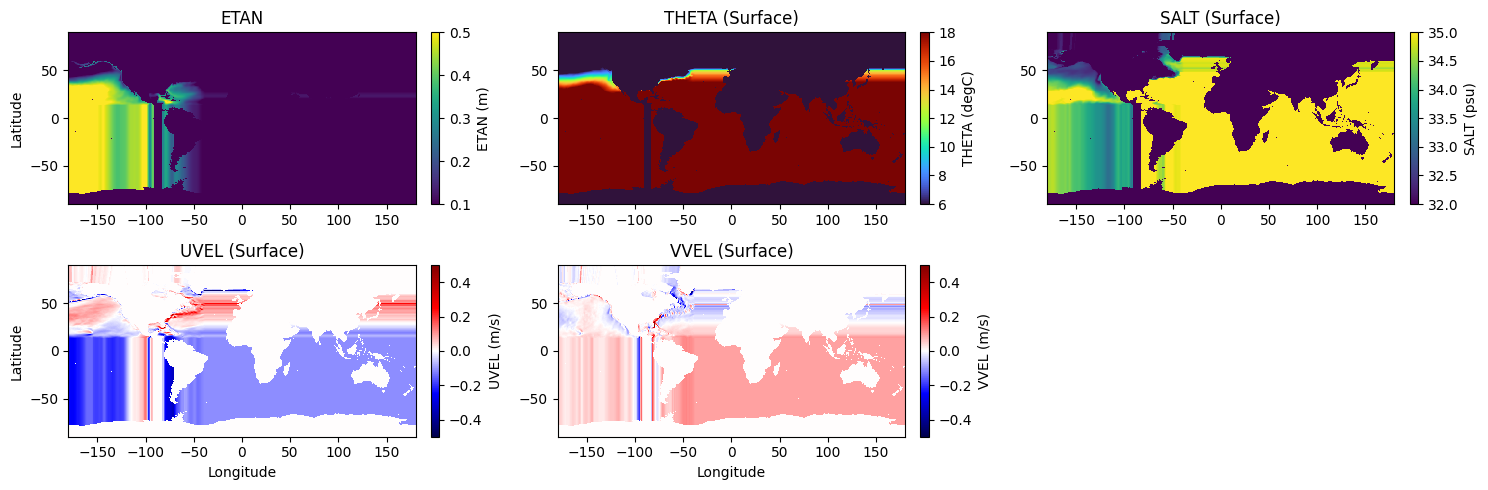



Step 6 completed in 1.10s. Plotted: ['ETAN', 'THETA', 'SALT', 'UVEL', 'VVEL']

--- Initial Conditions Generation Complete ---



In [9]:
print("--- Step Six: Plotting Fields ---\n")
start_step6_time = time.time()

meta_dict = {
    "ETAN": [0.1, 0.5, "viridis", "m"],
    "THETA": [6, 18, "turbo", "degC"],
    "SALT": [32, 35, "viridis", "psu"],
    "UVEL": [-0.5, 0.5, "seismic", "m/s"],
    "VVEL": [-0.5, 0.5, "seismic", "m/s"],
}

fig = plt.figure(figsize=(15, 5))

plot_successful = []

for i, variable_name in tqdm(enumerate(variable_names)):
    filepath = os.path.join(INPUT_DIR, f"{variable_name}_IC.bin")
    if not os.path.exists(filepath):
        print(f"Plotting skipped for {variable_name}: File not found ({filepath})")
        continue
    try:
        CA_init_grid_np = np.fromfile(filepath, ">f4")
        current_plot_n_levels = 1 if variable_name == "ETAN" else N_LEVELS_MODEL

        expected_shape_elements = N_ROWS * N_COLS
        if current_plot_n_levels > 1:
            expected_shape_elements *= current_plot_n_levels

        if CA_init_grid_np.size != expected_shape_elements:
            print(
                f"Warning: Size mismatch for {variable_name}. Expected {expected_shape_elements}, got {CA_init_grid_np.size}. Reshaping may fail."
            )
            # Fallback or skip if severe mismatch
            if (
                CA_init_grid_np.size % (N_ROWS * N_COLS) != 0
                and current_plot_n_levels > 1
            ):
                print(f"Cannot determine levels for {variable_name}. Skipping plot.")
                continue
            if current_plot_n_levels > 1:
                current_plot_n_levels = CA_init_grid_np.size // (N_ROWS * N_COLS)

        expected_shape = (
            (current_plot_n_levels, N_ROWS, N_COLS)
            if current_plot_n_levels > 1
            else (N_ROWS, N_COLS)
        )
        CA_init_grid_np = CA_init_grid_np.reshape(expected_shape)

        plot_data = (
            CA_init_grid_np[0, :, :]
            if current_plot_n_levels > 1 and CA_init_grid_np.ndim == 3
            else CA_init_grid_np
        )
        plot_title = (
            f"{variable_name} (Surface)" if current_plot_n_levels > 1 else variable_name
        )

        plt.subplot(2, 3, i + 1)
        meta = meta_dict.get(
            variable_name,
            [np.nanmin(plot_data), np.nanmax(plot_data), "viridis", "N/A"],
        )
        C = plt.pcolormesh(
            XC_np,
            YC_np,
            plot_data,
            vmin=meta[0],
            vmax=meta[1],
            cmap=meta[2],
            shading="auto",
        )
        plt.colorbar(C, label=f"{variable_name} ({meta[3]})", fraction=0.046, pad=0.04)
        plt.title(plot_title)
        if i >= 3:
            plt.xlabel("Longitude")
        if i % 3 == 0:
            plt.ylabel("Latitude")
        plot_successful.append(variable_name)
    except Exception as e:
        print(f"ERROR plotting {variable_name}: {e}")
if len(variable_names) == 5 and len(plot_successful) <= 5:
    if len(plot_successful) < 5:  # only add empty if less than 5 plots were successful
        ax = plt.subplot(2, 3, len(plot_successful) + 1)  # next available subplot
        ax.axis("off")
    elif len(plot_successful) == 5:  # if exactly 5 plots, the 6th is empty
        plt.subplot(2, 3, 6).axis("off")

plt.tight_layout()
plt.show()

step6_time = time.time() - start_step6_time
print(f"\n\nStep 6 completed in {step6_time:.2f}s. Plotted: {plot_successful}\n")
print("--- Initial Conditions Generation Complete ---\n")

## Step Seven: Run-Time Considerations

To use the grids as initial conditions in the model, I will specify them as "hydrography" conditions. Specifically, I will add the following lines to PARM05 of the data file:

```
hydrogThetaFile = 'THETA_IC.bin',
hydrogSaltFile = 'SALT_IC.bin',
uVelInitFile = 'UVEL_IC.bin',
vVelInitFile = 'VVEL_IC.bin',
pSurfInitFile = 'ETAN_IC.bin',
```